In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('./mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


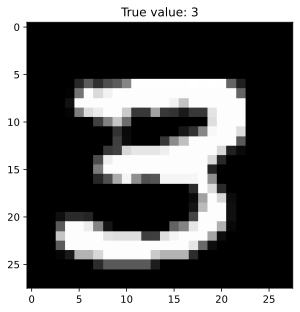

In [3]:
num = 111

plt.imshow(np.reshape(data[num, :], (28, 28)), cmap='gray')
plt.title(f"True value: {labels[num]}")
plt.show()

In [4]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_norm = train_data / torch.max(train_data)
test_norm = test_data / torch.max(test_data)


train_data = TensorDataset(train_norm, train_labels)
test_data = TensorDataset(test_norm, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
print(f'''Train data range {torch.min(train_data.tensors[0])} to {
torch.max(train_data.tensors[0])
}''')

print(f'''Test data range {torch.min(test_data.tensors[0])} to {
torch.max(test_data.tensors[0])
}''')

Train data range 0.0 to 1.0
Test data range 0.0 to 1.0


In [6]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x), axis=1)
        
    model = MnistNet()
    
    loss_fun = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [7]:
num_of_epochs = 60
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    test_losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        X,y = next(iter(test_loader))
        yHat = model(X)
        
        test_losses[epoch] = loss_func(yHat, y).item()
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, test_losses, model

# Normalize train and test data

In [8]:
train_acc, test_acc, train_losses, test_losses, model = train_model()

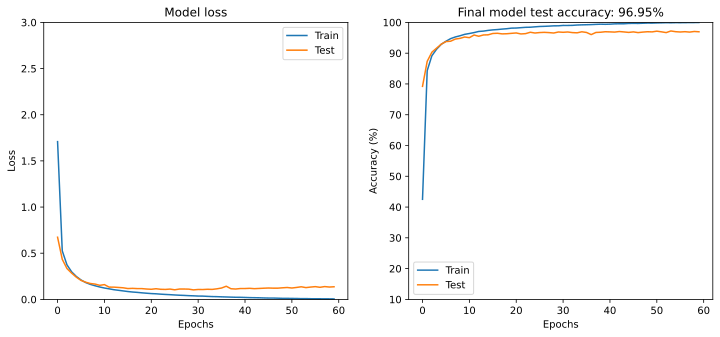

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()

# Normalize only train data

In [10]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_norm = train_data / torch.max(train_data)
# test_norm = test_data / torch.max(test_data)


train_data = TensorDataset(train_norm, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
print(f'''Train data range {torch.min(train_data.tensors[0])} to {
torch.max(train_data.tensors[0])
}''')

print(f'''Test data range {torch.min(test_data.tensors[0])} to {
torch.max(test_data.tensors[0])
}''')

Train data range 0.0 to 1.0
Test data range 0.0 to 255.0


In [12]:
train_acc, test_acc, train_losses, test_losses, model = train_model()

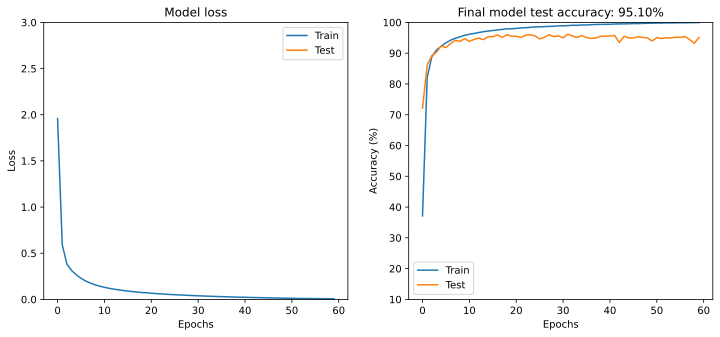

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()

# Normalize only test data

In [14]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# train_norm = train_data / torch.max(train_data)
test_norm = test_data / torch.max(test_data)


train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_norm, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [15]:
print(f'''Train data range {torch.min(train_data.tensors[0])} to {
torch.max(train_data.tensors[0])
}''')

print(f'''Test data range {torch.min(test_data.tensors[0])} to {
torch.max(test_data.tensors[0])
}''')

Train data range 0.0 to 255.0
Test data range 0.0 to 1.0


In [16]:
train_acc, test_acc, train_losses, test_losses, model = train_model()

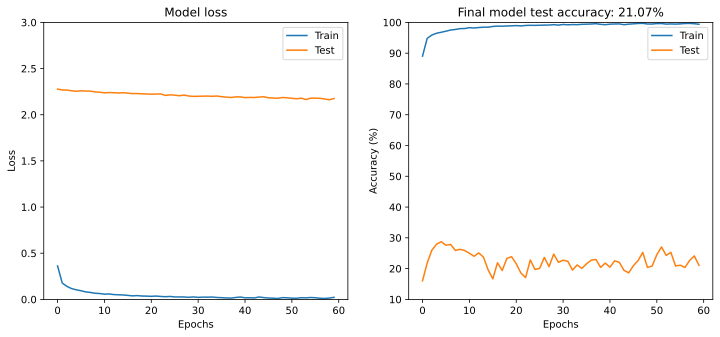

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()